# House Prices

Initilize project files and libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data: pd.DataFrame = pd.read_csv("data/train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
data.shape

(1460, 81)

### Get data matrices

In [26]:
numCols:int = data.shape[1]

X: pd.DataFrame = data.iloc[:, 1:-1] # Train data, we dont need id
Y: pd.DataFrame = data.iloc[:, -1:] # SalePrice is our targer variable

X.shape, Y.shape

((1460, 79), (1460, 1))

### Define some useful functions

#### define and check sigmoid

In [27]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))

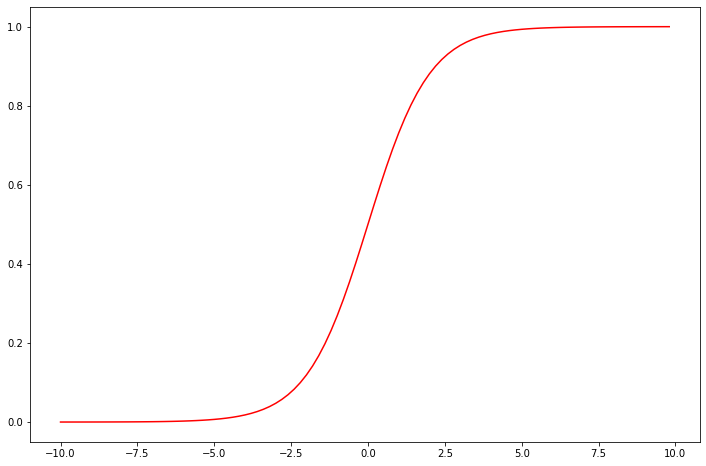

In [28]:
nums = np.arange(-10, 10, step=.2)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')